<a href="https://colab.research.google.com/github/MosesIbe23/CSE_450_Private/blob/main/Copy_of_starter_housing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [204]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

housing = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/housing.csv')
zip = pd.read_csv('https://raw.githubusercontent.com/joshuawiser/cse450data/refs/heads/main/wa_2021_zip.csv')

housing.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price
0,1565930130,20141104T000000,4,3.25,3760,4675,2.0,0,0,3,...,2740,1020,2007,0,98038,47.3862,-122.048,3280,4033,429900.0
1,3279000420,20150115T000000,3,1.75,1460,7800,1.0,0,0,2,...,1040,420,1979,0,98023,47.3035,-122.382,1310,7865,233000.0
2,194000575,20141014T000000,4,1.00,1340,5800,1.5,0,2,3,...,1340,0,1914,0,98116,47.5658,-122.389,1900,5800,455000.0
3,2115510160,20141208T000000,3,1.75,1440,8050,1.0,0,0,3,...,1440,0,1985,0,98023,47.3187,-122.390,1790,7488,258950.0
4,7522500005,20140815T000000,2,1.50,1780,4750,1.0,0,0,4,...,1080,700,1947,0,98117,47.6859,-122.395,1690,5962,555000.0


In [205]:

#Binning 'bedrooms' and 'sqft_living' into groups and categories respectively

housing['date'] = pd.to_datetime(housing['date'])
housing['year_sold'] = housing['date'].dt.year
housing['month_sold'] = housing['date'].dt.month
housing['season_sold'] = housing['month_sold'].apply(lambda x: 1 if x in [12, 1, 2] else (2 if x in [3, 4, 5] else (3 if x in [6, 7, 8] else 4)))
housing.drop('date', axis=1, inplace=True)
housing.drop('month_sold', axis=1, inplace=True)
housing.drop('id', axis=1, inplace=True)

zip_columns_to_keep = ['zipcode','agi_stub','N1']
zip = zip[zip_columns_to_keep]
zip['multiplied'] = zip['agi_stub'] * zip['N1']
zip = zip.groupby('zipcode').sum()
zip['overall_rank'] = zip['multiplied']/zip['N1']
columns_to_keep = ['overall_rank']
zip = zip[columns_to_keep]
zip.reset_index(inplace=True)

housing = pd.merge(housing, zip, on='zipcode', how = 'left')

mean_price_zip = housing.groupby('zipcode')['price'].mean()
housing['average_price'] = housing['zipcode'].map(mean_price_zip)
housing.drop('zipcode', axis=1, inplace=True)
housing.drop(housing[housing['price']> 6500000].index, inplace = True)

housing['bedrooms'] = pd.cut(housing['bedrooms'], bins=[0, 2, 4, 6, np.inf], labels=['0-2', '3-4', '5-6', '7+'])
housing['bathrooms'] = pd.cut(housing['bathrooms'], bins=[0, 2, 4, 6, np.inf], labels=['0-1.75', '2-3.75', '4-5.75', '6+'])
housing['sqft_living'] = pd.cut(housing['sqft_living'], bins=[0, 1000, 2000, 3000, 4000, np.inf], labels=['0-999', '1000-1999', '2000-2999', '3000-3999', '4000+'])
housing['sqft_lot'] = pd.cut(housing['sqft_lot'], bins=[0, 10000, 20000, 30000, 40000, np.inf], labels=['0-9999', '10000-19999', '20000-29999', '30000-39999', '40000+'])
housing['sqft_above'] = pd.cut(housing['sqft_above'], bins=[0, 1000, 2000, 3000, 4000,np.inf], labels=['0-999', '1000-1999', '2000-2999', '3000-3999', '4000+'])
housing['sqft_basement'] = pd.cut(housing['sqft_basement'], bins=[0, 500, 1000, 1500, 2000, np.inf], labels=['0-499', '500-999', '1000-1499', '1500-1999', '2000+'])
housing['average_price'] = pd.cut(housing['average_price'], bins=[0, 100000, 200000, 300000, 400000, 500000, 600000, np.inf], labels=['0-99999', '100000-199999', '200000-299999', '300000-399999', '400000-499999', '500000-599999', '600000+'])

housing

<ipython-input-205-a295029eab27>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  zip['multiplied'] = zip['agi_stub'] * zip['N1']


,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,...,yr_renovated,lat,long,sqft_living15,sqft_lot15,price,year_sold,season_sold,overall_rank,average_price
0,3-4,2-3.75,3000-3999,0-9999,2.0,0,0,3,8,2000-2999,...,0,47.3862,-122.048,3280,4033,429900.0,2014,4,3.790614,300000-399999
1,3-4,0-1.75,1000-1999,0-9999,1.0,0,0,2,7,1000-1999,...,0,47.3035,-122.382,1310,7865,233000.0,2015,1,2.996308,200000-299999
2,3-4,0-1.75,1000-1999,0-9999,1.5,0,2,3,7,1000-1999,...,0,47.5658,-122.389,1900,5800,455000.0,2014,4,3.821218,600000+
3,3-4,0-1.75,1000-1999,0-9999,1.0,0,0,3,8,1000-1999,...,0,47.3187,-122.390,1790,7488,258950.0,2014,1,2.996308,200000-299999
4,0-2,0-1.75,1000-1999,0-9999,1.0,0,0,4,7,1000-1999,...,0,47.6859,-122.395,1690,5962,555000.0,2014,3,4.000544,500000-599999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,3-4,0-1.75,0-999,0-9999,1.0,0,0,3,7,0-999,...,0,47.7144,-122.319,1000,6947,378000.0,2014,4,3.265287,400000-499999
19996,3-4,2-3.75,3000-3999,0-9999,2.0,0,0,3,8,3000-3999,...,0,47.2974,-122.349,2927,5183,399950.0,2014,4,2.996308,200000-299999
19997,3-4,2-3.75,2000-2999,0-9999,2.0,0,0,3,7,2000-2999,...,0,47.6810,-122.032,1690,2650,575000.0,2014,4,4.239000,600000+
19998,0-2,0-1.75,0-999,10000-19999,1.0,0,0,3,5,0-999,...,0,47.4810,-122.323,1170,15000,245000.0,2014,3,2.719396,200000-299999


In [210]:

# Split features and target
X = housing.drop(columns=['price'])
y = housing['price']

# Convert categorical variables to numerical using one-hot encoding
X = pd.get_dummies(X)

# Split the data into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X


,floors,waterfront,view,condition,grade,yr_built,yr_renovated,lat,long,sqft_living15,...,sqft_basement_1000-1499,sqft_basement_1500-1999,sqft_basement_2000+,average_price_0-99999,average_price_100000-199999,average_price_200000-299999,average_price_300000-399999,average_price_400000-499999,average_price_500000-599999,average_price_600000+
0,2.0,0,0,3,8,2007,0,47.3862,-122.048,3280,...,True,False,False,False,False,False,True,False,False,False
1,1.0,0,0,2,7,1979,0,47.3035,-122.382,1310,...,False,False,False,False,False,True,False,False,False,False
2,1.5,0,2,3,7,1914,0,47.5658,-122.389,1900,...,False,False,False,False,False,False,False,False,False,True
3,1.0,0,0,3,8,1985,0,47.3187,-122.390,1790,...,False,False,False,False,False,True,False,False,False,False
4,1.0,0,0,4,7,1947,0,47.6859,-122.395,1690,...,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,1.0,0,0,3,7,1947,0,47.7144,-122.319,1000,...,False,False,False,False,False,False,False,True,False,False
19996,2.0,0,0,3,8,2014,0,47.2974,-122.349,2927,...,False,False,False,False,False,True,False,False,False,False
19997,2.0,0,0,3,7,2004,0,47.6810,-122.032,1690,...,False,False,False,False,False,False,False,False,False,True
19998,1.0,0,0,3,5,1963,0,47.4810,-122.323,1170,...,False,False,False,False,False,True,False,False,False,False


In [221]:
xgb_model = XGBRegressor(random_state=42, n_estimators=300, max_depth=3, learning_rate = 0.3, early_stopping_rounds = 50)
xgb_model.fit(X_train_scaled, y_train, eval_set=[(X_test_scaled, y_test)], verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.3, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=300, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [222]:
y_pred = xgb_model.predict(X_test_scaled)

# Calculate evaluation metrics
mse = round(mean_squared_error(y_test, y_pred), 2)
mae = round(mean_absolute_error(y_test, y_pred), 2)
rmse = round(np.sqrt(mse), 2)
r2 = round(r2_score(y_test, y_pred)*100, 2)

# Print the results
print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"R²: {r2}%")


MSE: 13857684100.09
MAE: 70109.03
RMSE: 117718.67
R²: 90.2%


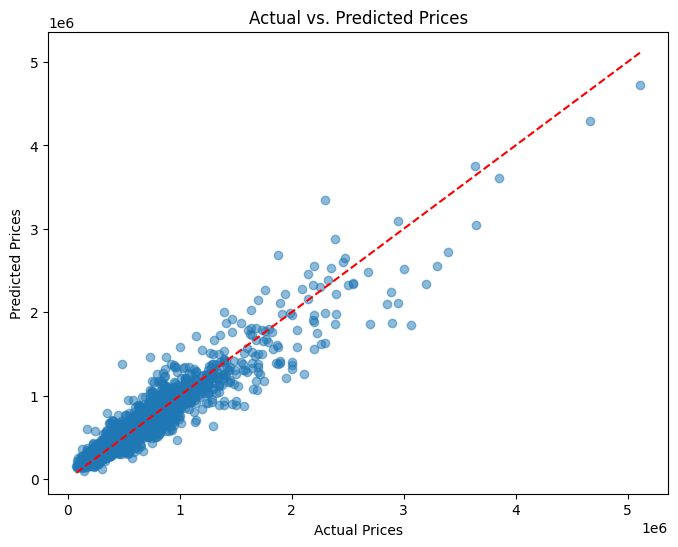

In [223]:
# Create a scatter plot of actual vs. predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')  # Diagonal line (perfect predictions)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs. Predicted Prices')
plt.show()

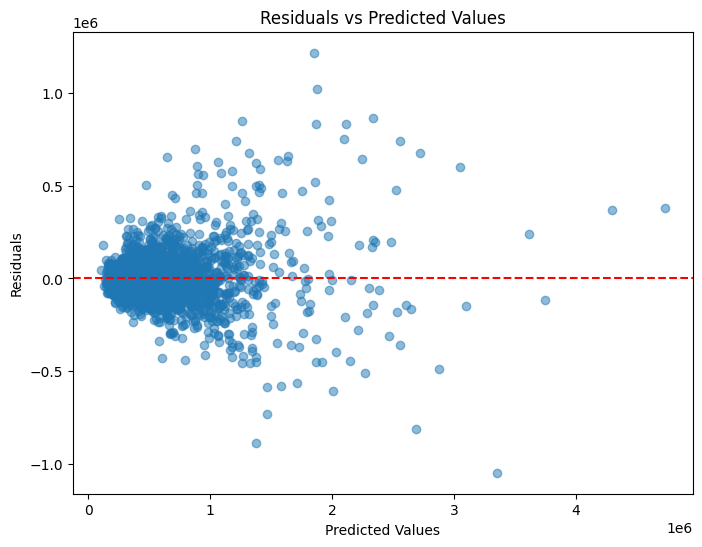

In [224]:
residuals = y_test - y_pred

plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.show()

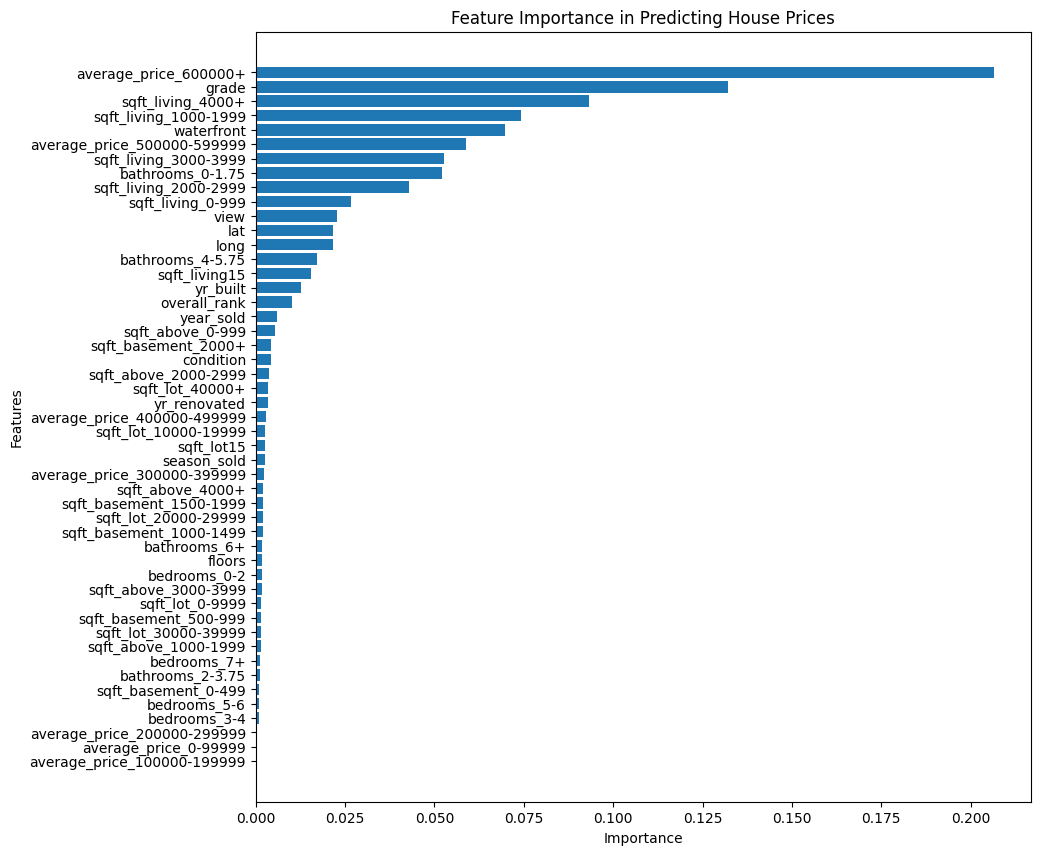

In [229]:
# Get feature importance from the trained XGBoost model
feature_importance = xgb_model.feature_importances_

# Create a bar chart to visualize feature importance
features = X.columns  # Get the column names
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importance
})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 10))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance in Predicting House Prices')
plt.gca().invert_yaxis()  # Invert the y-axis to have the most important features at the top
plt.show()